# Trying out the simplest reasonable classifier - LDA
### Assuming the network configuration at every point in time is an independent draw from 1 of two Gaussians with different means and identical covariance

In [1]:
import matplotlib.pyplot as plt

import scipy as sp
import scipy.io
import numpy as np
import os
os.sys.path.append('../behavior')
os.sys.path.append('../')
from behavior_analysis import process_data as pd
from behavior_analysis import loadmat_sbx

import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import pandas 

from utilities import load_ca_mat, trial_tensor, across_trial_avg
import utilities


%load_ext autoreload
%autoreload 2

%matplotlib inline

C:\Users\mplitt\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [13]:

vr_dir = "Z://VR/2AFC_V3/"

In [2]:

mouse = "4058541.1"
CaDataDir = "Z://2P_data/2AFC_V3/" + mouse + "/CA1/"
CaFiles = ["CA1_001_004", "CA1_002_008", "CA1_003_002","CA1_004_002","CA1_005_001"] 

BehaviorFiles = ["1_imaging_","2_imaging_3_",  "3_", "4_imaging_", "5_imaging_"]

In [19]:
mouse = "4058541.3"
CaDataDir = "Z://2P_data/2AFC_V3/" + mouse + "/CA1//"
CaFiles = ["CA1_001_002" ,"CA1_002_002", "CA1_003_002","CA1_004_001","CA1_005_002"] 
BehaviorFiles = ["1_imaging_",  "2_", "3_", "4_imaging_", "5_imaging_"]

In [ ]:
CaDataDir = "Z://2P_data/2AFC_V3/" + mouse + "/CA1//"
CaFiles = ["GEN_001_002" ] 
BehaviorFiles = ["1_imaging_",  "2_", "3_", "4_imaging_", "5_imaging_"]

In [20]:
sessions = []
Behavior = []
Ca_Dat = []
TStartI = []
RewardI = []

for i in range(len(CaFiles)):
    info = loadmat_sbx(CaDataDir + "/rawDat/" + CaFiles[i] + ".mat")['info']
    sess = "2AFC_Test_PostSurg_" + BehaviorFiles[i]
    c = pd(mouse,sess,basedir='work')
    if mouse=="4058541.3":
        behavior,tstart_inds,reward_inds,first_lick_inds = c.align_to_ca(sess,info,nplanes=2)
    else:
        behavior,tstart_inds,reward_inds,first_lick_inds = c.align_to_ca(sess,info,nplanes=1)
    
    fname= CaDataDir+ CaFiles[i] +"_cnmf_results.mat"
    print(fname)
    ca_dat = load_ca_mat(fname)
    
    sessions.append(sess)
    Behavior.append(behavior)
    Ca_Dat.append(ca_dat)
    TStartI.append(tstart_inds)
    RewardI.append(reward_inds)


Z://2P_data/2AFC_V3/4058541.3/CA1///rawDat/CA1_001_002.mat
(246,)
(246,)
(245, 4)
Z://2P_data/2AFC_V3/4058541.3/CA1//CA1_001_002_cnmf_results.mat
#subsystem#not made into numpy array
Z://2P_data/2AFC_V3/4058541.3/CA1///rawDat/CA1_002_002.mat
(246,)
(246,)
(245, 4)
Z://2P_data/2AFC_V3/4058541.3/CA1//CA1_002_002_cnmf_results.mat
#subsystem#not made into numpy array
Z://2P_data/2AFC_V3/4058541.3/CA1///rawDat/CA1_003_002.mat
(246,)
(246,)
(245, 4)
Z://2P_data/2AFC_V3/4058541.3/CA1//CA1_003_002_cnmf_results.mat
#subsystem#not made into numpy array
Z://2P_data/2AFC_V3/4058541.3/CA1///rawDat/CA1_004_001.mat
(246,)
(246,)
(245, 4)
Z://2P_data/2AFC_V3/4058541.3/CA1//CA1_004_001_cnmf_results.mat
#subsystem#not made into numpy array
Z://2P_data/2AFC_V3/4058541.3/CA1///rawDat/CA1_005_002.mat
(246,)
(246,)
(245, 4)
Z://2P_data/2AFC_V3/4058541.3/CA1//CA1_005_002_cnmf_results.mat
#subsystem#not made into numpy array


In [31]:
# LOO Trial Out Cross Validation
Accuracy = []
for i in range(len(CaFiles)):
    print(sessions[i])
    ca_dat, behavior, tstart_inds, reward_inds = Ca_Dat[i], Behavior[i], TStartI[i], RewardI[i]
    C_dec = sp.stats.zscore(ca_dat['C_dec'][behavior['ca_inds'].values,:],axis=0)
    # restrict to extreme morphs answered correctly
    base_trial_mask = np.where(((behavior['morph'].values==1) | (behavior['morph'].values==0)) & 
                          ((behavior['rewards']==1) | (behavior['rewards']==-1) | 
                           (behavior['rewards']==2)|(behavior['rewards']==-2)))[0]

    

    #convert tstart and reward indices
    tstart_inds_base = np.zeros(behavior['morph'].values.shape)
    tstart_inds_base[tstart_inds] = 1
    tstart_inds_base = np.where(tstart_inds_base[base_trial_mask]>0)[0]

    reward_inds_base = np.zeros(behavior['morph'].values.shape)
    reward_inds_base[reward_inds] = 1
    reward_inds_base = np.where(reward_inds_base[base_trial_mask]>0)[0]

    C_base = C_dec[base_trial_mask,:]
    morph_base = behavior['morph'].values[base_trial_mask]

    all_inds = np.arange(C_base.shape[0])
    last_inds = np.append(tstart_inds_base[1:]-1,C_base.shape[0])
    true_labels, majority_vote = [],[]
    for tmp, (first_ind,reward_ind,last_ind) in enumerate(zip(tstart_inds_base.tolist(),reward_inds_base.tolist(),last_inds)):
        trainInds = np.where((all_inds<first_ind) | (all_inds>last_ind))[0]
        testInds = np.where((all_inds>=first_ind) & (all_inds<=last_ind))[0]

        C_train,C_test = C_base[trainInds,:],C_base[testInds,:]
        train_labels, test_label = morph_base[trainInds], morph_base[testInds]
        true_labels.append(test_label[0])
        lda = LDA(n_components=1)
        C_train_lda = lda.fit_transform(C_train,train_labels)

        y_hat = lda.predict(C_test).mean()
        if y_hat>.5:
            majority_vote.append(1)

        else:
            majority_vote.append(0)

    acc = 0
    for guess, true in zip(majority_vote,true_labels):
        if guess == true:
            acc+=1
    acc/=len(majority_vote)
    Accuracy.append(acc)
    print(sessions[i] + "LDA accuracy: %f" % acc)

2AFC_Test_PostSurg_1_imaging_
2AFC_Test_PostSurg_1_imaging_LDA accuracy: 0.908571
2AFC_Test_PostSurg_2_
2AFC_Test_PostSurg_2_LDA accuracy: 0.880435
2AFC_Test_PostSurg_3_
2AFC_Test_PostSurg_3_LDA accuracy: 0.876847
2AFC_Test_PostSurg_4_imaging_
2AFC_Test_PostSurg_4_imaging_LDA accuracy: 0.797980
2AFC_Test_PostSurg_5_imaging_
2AFC_Test_PostSurg_5_imaging_LDA accuracy: 0.783251


## Calculate projection onto discriminant axis at each time point and align to trial and reward onsets

2AFC_Test_PostSurg_1_imaging_
(9, 100, 1)
2AFC_Test_PostSurg_2_
(9, 100, 1)
2AFC_Test_PostSurg_3_
(9, 100, 1)
2AFC_Test_PostSurg_4_imaging_
(9, 100, 1)
2AFC_Test_PostSurg_5_imaging_
(9, 100, 1)


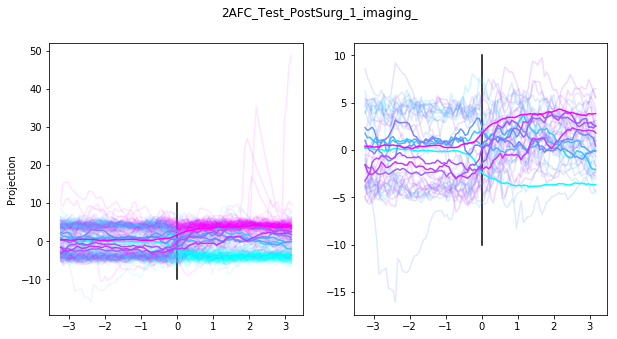

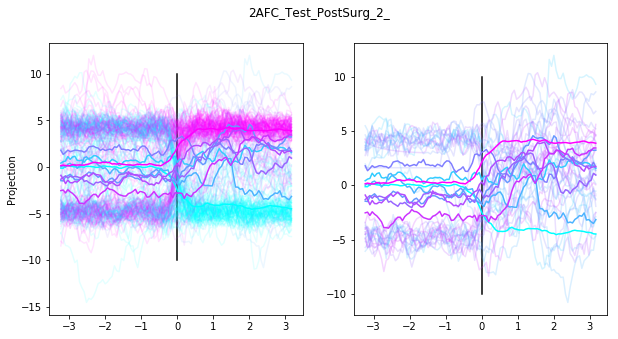

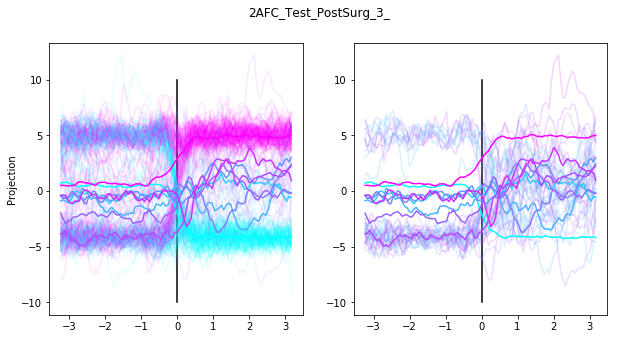

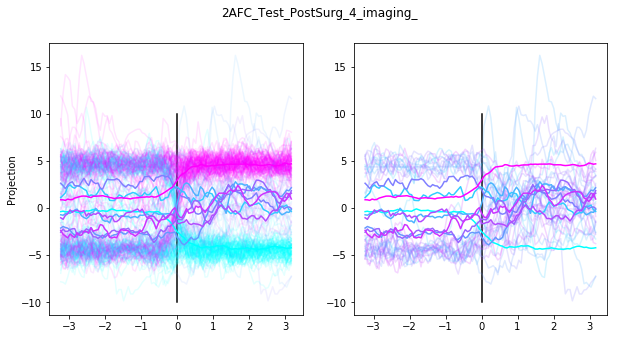

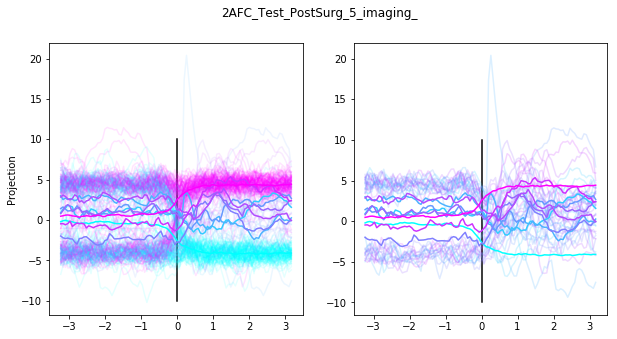

In [21]:
# single session projections
LDAs = []

for i in range(len(CaFiles)):
    f,ax = plt.subplots(1,2,figsize=[10,5])
    plt.suptitle(sessions[i],figure= f,size='large')

    ax[0].plot([0, 0], [-10, 10],c='black')
    ax[1].plot([0, 0], [-10, 10],c='black')
    
    
    
    
    print(sessions[i])
    ca_dat, behavior, tstart_inds, reward_inds = Ca_Dat[i], Behavior[i], TStartI[i], RewardI[i]
    C_dec = sp.stats.zscore(ca_dat['C_dec'][behavior['ca_inds'].values,:],axis=0)
    base_trial_mask = np.where(((behavior['morph'].values==1) | (behavior['morph'].values==0)) & 
                              ((behavior['rewards']==1) | (behavior['rewards']==-1) | 
                               (behavior['rewards']==2)|(behavior['rewards']==-2)))[0]
    lda = LDA(n_components=1)
    C_base_lda = lda.fit_transform(C_dec[base_trial_mask,:],behavior['morph'].values[base_trial_mask])
    C_lda = lda.transform(C_dec)
    

    LDAs.append(lda)
    
    trialMat_proj, morphVec = trial_tensor(C_lda,behavior['morph'].values,tstart_inds)
    
    morphAvg_proj, morphVals = across_trial_avg(trialMat_proj,morphVec)
    

    ax[0].set_ylabel("Projection")
    for ind,t in enumerate(tstart_inds.tolist()):
        ax[0].plot(np.arange(-50,50)/15.46,trialMat_proj[ind,:,:],c=plt.cm.cool(morphVec[ind]),alpha=.1)
        

        if (morphVec[ind]!=1.0) and (morphVec[ind]!=0.0):
            ax[1].plot(np.arange(-50,50)/15.46,trialMat_proj[ind,:,:],c=plt.cm.cool(behavior['morph'].values[t]),alpha=.2)
            

    print(morphAvg_proj.shape)
    for i,val in enumerate(morphVals.tolist()):
        ax[0].plot(np.arange(-50,50)/15.46,np.squeeze(morphAvg_proj[i,:]),c=plt.cm.cool(val))
        ax[1].plot(np.arange(-50,50)/15.46,np.squeeze(morphAvg_proj[i,:]),c=plt.cm.cool(val))


## Normalize projections and average across session

next 
(245, 100, 1)
16629 50
16661
(82,)
next 
(245, 100, 1)
17278 50
17305
(77,)
(245, 65, 1)
17261 50
17305
(59,)
next 
(245, 100, 1)
15986 50
16014
(78,)
(245, 65, 1)
15971 50
16014
(58,)
next 
(245, 100, 1)
15588 50
15614
(76,)
(245, 65, 1)
15568 50
15614
(61,)
next 
(245, 100, 1)
17060 50
17092
(82,)
(82686, 1) (82686,) (82686,)


Text(0.5,1,'Average Normalized Projection')

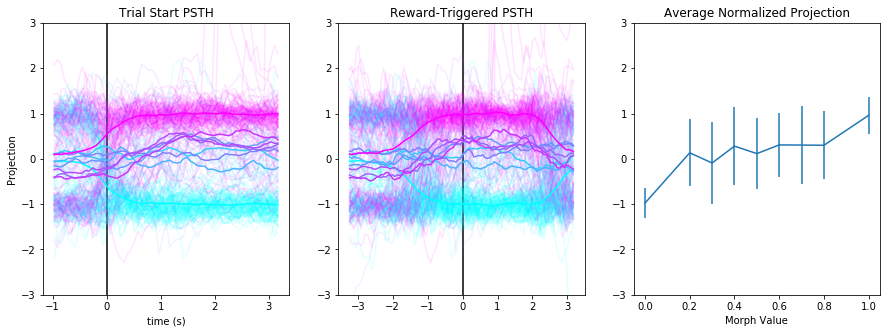

In [29]:
f,ax = plt.subplots(1,3,figsize=[15,5])
for i in range(len(CaFiles)):
    print("next ")
    ca_dat, behavior, tstart_inds, reward_inds = Ca_Dat[i], Behavior[i], TStartI[i], RewardI[i]
    lda = LDAs[i]
    C_dec = sp.stats.zscore(ca_dat['C_dec'][behavior['ca_inds'].values,:],axis=0)
    if i == 0:
        C_lda = sp.stats.zscore(lda.transform(C_dec))
        trialMat_reward, morphVec = trial_tensor(C_lda[:,0],behavior['morph'].values,np.array(reward_inds))
        trialMat_start, morphVec = trial_tensor(C_lda[:,0],behavior['morph'].values,tstart_inds,pre=15,post =50)
        position, rewards, morphs = behavior['position'].values,behavior['rewards'].values, behavior['morph'].values

    else:
        C_lda_tmp = sp.stats.zscore(lda.transform(C_dec))
        C_lda = np.append(C_lda,C_lda_tmp,axis=0)

        tmp_reward, tmp_morphVec = trial_tensor(C_lda_tmp[:,0],behavior['morph'].values,np.array(reward_inds))
        tmp_start, tmp_morphVec = trial_tensor(C_lda_tmp[:,0],behavior['morph'].values,tstart_inds,pre=15,post=50)

        trialMat_reward= np.append(trialMat_reward,tmp_reward,axis=0)
        trialMat_start= np.append(trialMat_start,tmp_start,axis=0)
        morphVec = np.append(morphVec,tmp_morphVec,axis=0)
        position = np.append(position,behavior['position'].values)
        rewards = np.append(rewards,behavior['rewards'].values)
        morphs = np.append(morphs,behavior['morph'].values)

morphAvg_start, morphVals = across_trial_avg(trialMat_start,morphVec)
morphAvg_reward, morphVals = across_trial_avg(trialMat_reward,morphVec)


grand_avg_proj =np.zeros(morphVals.shape)
sem_proj = np.zeros(morphVals.shape)
print(C_lda.shape, morphs.shape, position.shape)
for i, val in enumerate(morphVals.tolist()):
    grand_avg_proj[i] = C_lda[(morphs==val)&(position>0)].mean()
    sem_proj[i] = np.std(C_lda[(morphs==val)&(position>0)],axis=0)
    
ax[0].plot([0, 0], [-3, 3],c='black')
ax[1].plot([0, 0], [-3, 3],c='black')

for ind,t in enumerate(tstart_inds):
    ax[0].plot(np.arange(-15,50)/15.46,trialMat_start[ind,:,:],c=plt.cm.cool(morphVec[ind]),alpha=.1)
    ax[1].plot(np.arange(-50,50)/15.46,trialMat_reward[ind,:,:],c=plt.cm.cool(morphVec[ind]),alpha=.1)

for ind,val in enumerate(morphVals.tolist()):
    ax[0].plot(np.arange(-15,50)/15.46,morphAvg_start[ind,:],c=plt.cm.cool(val))
    ax[1].plot(np.arange(-50,50)/15.46,morphAvg_reward[ind,:],c=plt.cm.cool(val))

    
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('Projection')
ax[0].set_title('Trial Start PSTH')
ax[0].set_ylim([-3, 3])
ax[1].set_title('Reward-Triggered PSTH')
ax[1].set_ylim([-3, 3])
#ax[2].plot(morphVals,grand_avg_prob)
ax[2].errorbar(morphVals,grand_avg_proj,yerr=sem_proj)
ax[2].set_xlabel('Morph Value')
ax[2].set_ylim([-3,3])
ax[2].set_title('Average Normalized Projection')

In [32]:
# error trial predictions
for i in range(len(CaFiles)):
    print(sessions[i])
    ca_dat, behavior, tstart_inds, reward_inds = Ca_Dat[i], Behavior[i], TStartI[i], RewardI[i]
    C_dec = sp.stats.zscore(ca_dat['C_dec'][behavior['ca_inds'].values,:],axis=0)
    # restrict to extreme morphs answered correctly
    base_trial_mask = np.where(((behavior['morph'].values==1) | (behavior['morph'].values==0)) & 
                          ((behavior['rewards']==1) | (behavior['rewards']==-1) | 
                           (behavior['rewards']==2)|(behavior['rewards']==-2)))[0]

    error_trial_mask = np.where(((behavior['morph'].values==1) | (behavior['morph'].values==0)) & 
                          ((behavior['rewards']==3) | (behavior['rewards']==-3) | 
                           (behavior['rewards']==4)|(behavior['rewards']==-4)))[0]
    
    morph_trial_mask = np.where((behavior['morph'].values!=1)|(behavior['morph'].values!=0))[0]

    print(error_trial_mask.shape)
    #convert tstart and reward indices
    tstart_inds_error = np.zeros(behavior['morph'].values.shape)
    tstart_inds_error[tstart_inds] = 1
    tstart_inds_error = np.where(tstart_inds_error[error_trial_mask]>0)[0]
    
    reward_inds_error = np.zeros(behavior['morph'].values.shape)
    reward_inds_error[reward_inds] = 1
    reward_inds_error = np.where(reward_inds_error[error_trial_mask]>0)[0]

    
    
    
    # train classifier on baseline correct trials
    C_base = C_dec[base_trial_mask,:]
    morph_base = behavior['morph'].values[base_trial_mask]
    lda = LDA(n_components=1)
    lda.fit(C_base,morph_base)
    
    
    C_error = C_dec[error_trial_mask,:]
    morph_error = behavior['morph'].values[error_trial_mask]
    all_inds = np.arange(C_error.shape[0])
    last_inds = np.append(tstart_inds_error[1:]-1,C_error.shape[0])
    context_labels_error, majority_vote_error = [],[]
    for tmp, (first_ind,reward_ind,last_ind) in enumerate(zip(tstart_inds_error.tolist(),reward_inds_error.tolist(),last_inds)):
        testInds = np.where((all_inds>=first_ind) & (all_inds<=last_ind))[0]
        
        C_test = C_error[testInds,:]
        context_labels_error.append(morph_error[testInds][0])
        
        
        y_hat = lda.predict(C_test).mean()
        if y_hat>.5:
            majority_vote_error.append(1)
        else:
            majority_vote_error.append(0)

    acc = 0
    for guess, true in zip(majority_vote_error,context_labels_error):
        if guess == true:
            acc+=1
    acc/=len(majority_vote_error)
    Accuracy.append(acc)
    print(sessions[i] + "LDA accuracy on error trials: %f" % acc)

2AFC_Test_PostSurg_1_imaging_
(3857,)
2AFC_Test_PostSurg_1_imaging_LDA accuracy on error trials: 0.685714
2AFC_Test_PostSurg_2_
(2851,)
2AFC_Test_PostSurg_2_LDA accuracy on error trials: 0.615385
2AFC_Test_PostSurg_3_
(795,)
2AFC_Test_PostSurg_3_LDA accuracy on error trials: 0.714286
2AFC_Test_PostSurg_4_imaging_
(1282,)
2AFC_Test_PostSurg_4_imaging_LDA accuracy on error trials: 0.583333
2AFC_Test_PostSurg_5_imaging_
(813,)
2AFC_Test_PostSurg_5_imaging_LDA accuracy on error trials: 0.714286


In [ ]:
# tstart_inds_morph = np.zeros(behavior['morph'].values.shape)
#     tstart_inds_morph[tstart_inds] = 1
#     tstart_inds_morph = np.where(tstart_inds_morph[error_trial_mask]>0)[0]
    
#     reward_inds_morph = np.zeros(behavior['morph'].values.shape)
#     reward_inds_morph[reward_inds] = 1
#     reward_inds_morph = np.where(reward_inds_morph[morph_trial_mask]>0)[0]


In [26]:
#psychometric and nerometric functions

## Look at sparsity of projection onto discriminant

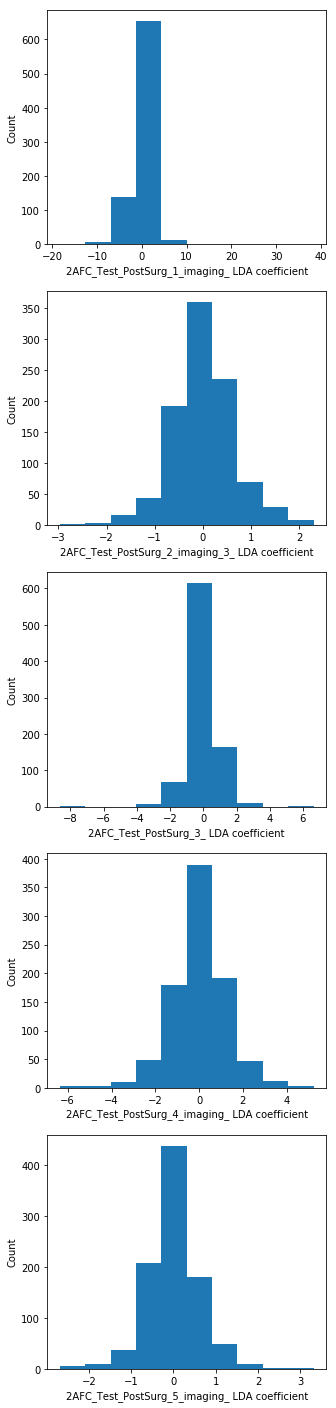

In [32]:

# give a histogram of weights on the LDA discriminant
f,ax = plt.subplots(5,1,figsize=[5,25])
for i in range(len(CaFiles)):
    c,bins,patches=ax[i].hist(LDAs[i].coef_.ravel())
    ax[i].set_xlabel("%s LDA coefficient" % sessions[i])
    ax[i].set_ylabel('Count')

## Check if LDA discriminant coefficient correlates with spatial information

spatial information v |LDA coefficient| correlation: -0.163636
spatial information v |LDA coefficient| correlation: -0.090851
spatial information v |LDA coefficient| correlation: -0.137300
spatial information v |LDA coefficient| correlation: -0.158635
spatial information v |LDA coefficient| correlation: -0.154927


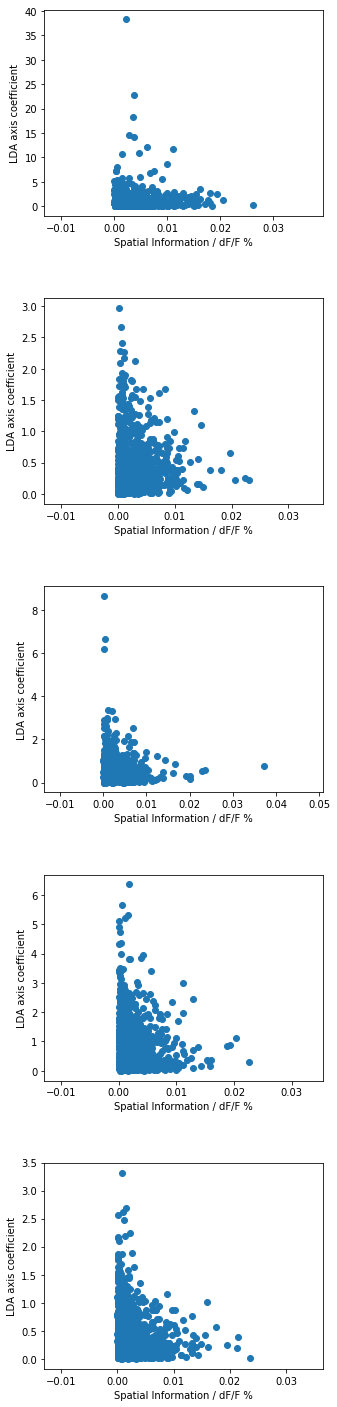

In [38]:
f,ax = plt.subplots(5,1,figsize=[5,25])
f.subplots_adjust(hspace=.4)
for i in range(len(CaFiles)):

    ca_dat, behavior, tstart_inds, reward_inds = Ca_Dat[i], Behavior[i], TStartI[i], RewardI[i]
    lda = LDAs[i]
    C_raw = ca_dat['C_dec'][behavior['ca_inds'].values,:]

    frmap, occupancy = utilities.rate_map(C_raw,behavior['position'].values)
    SI = utilities.spatial_info(frmap,occupancy)
    
    ax[i].scatter(SI,np.abs(lda.coef_.ravel()))
    ax[i].set_xlabel('Spatial Information / dF/F %')
    ax[i].set_ylabel('LDA axis coefficient')
    
    r,p = sp.stats.spearmanr(SI,np.abs(lda.coef_.ravel()))
    print('spatial information v |LDA coefficient| correlation: %f' % r)